# Exploratory Data Analysis

* This notebook uses a preprocessed dataset available at the following link https://github.com/jroccal/hydropower_energy_forecasting/blob/main/notebooks/preprocessing.ipynb

* The objective of this notebook is to explore the dataset to identify key characteristics and patterns in both the features and the target variable. The insights gained from this analysis can help guide feature engineering, the selection of appropriate machine learning models, cross-validation strategies, and more.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path_data = 'hydropower-zindi-challenge/'

In [ ]:

df_data = pd.read_parquet(path_data+'df_daily_energy_data.parquet')
df_climate = pd.read_parquet(path_data+'df_daily_climate_data.parquet')
df_data.shape, df_climate.shape

((136409, 25), (511, 27))

In [ ]:
df_data.columns

Index(['source_original', 'date', 'v_red_mean', 'v_red_std', 'v_red_median',
       'v_blue_mean', 'v_blue_std', 'v_blue_median', 'v_yellow_mean',
       'v_yellow_std', 'v_yellow_median', 'current_mean', 'current_std',
       'current_median', 'power_factor_mean', 'power_factor_std',
       'power_factor_median', 'kwh', 'month', 'year', 'day', 'is_three_phases',
       'voltage', 'consumer_device', 'data_user'],
      dtype='object')

In [ ]:
df_data.head()

,source_original,date,v_red_mean,v_red_std,v_red_median,v_blue_mean,v_blue_std,v_blue_median,v_yellow_mean,v_yellow_std,...,power_factor_std,power_factor_median,kwh,month,year,day,is_three_phases,voltage,consumer_device,data_user
0,consumer_device_3_data_user_10,2023-06-03,1.343381,15.838232,0.0,NaN,NaN,NaN,NaN,NaN,...,0.062766,0.0,0.000921,6.0,2023.0,3.0,0.0,1.343381,consumer_device_3,10
1,consumer_device_3_data_user_6,2023-06-03,NaN,NaN,NaN,1.34482,15.855196,0.0,NaN,NaN,...,0.067855,0.0,0.000997,6.0,2023.0,3.0,1.0,1.344820,consumer_device_3,6
2,consumer_device_3_data_user_3,2023-06-03,1.343381,15.838232,0.0,NaN,NaN,NaN,NaN,NaN,...,0.064462,0.0,0.001183,6.0,2023.0,3.0,0.0,1.343381,consumer_device_3,3
3,consumer_device_3_data_user_11,2023-06-03,NaN,NaN,NaN,NaN,NaN,NaN,1.34482,15.855196,...,0.061070,0.0,0.001009,6.0,2023.0,3.0,1.0,1.344820,consumer_device_3,11
4,consumer_device_3_data_user_9,2023-06-03,NaN,NaN,NaN,NaN,NaN,NaN,1.34482,15.855196,...,0.062766,0.0,0.000922,6.0,2023.0,3.0,1.0,1.344820,consumer_device_3,9


## 1. check null columns

In [ ]:
def type_and_nulls(df, p_nulls=90, display_null_features=True):
    num_rows = df.shape[0]
    num_colums = df.shape[1]
    df_type = pd.concat([pd.DataFrame(df.dtypes), df.isnull().sum().to_frame().rename(columns={0:'nulls'})], axis=1)
    df_type.rename(columns={0:'dtype'}, inplace=True)

    not_nulls = list((df_type[df_type['nulls']==0]).index)
    nulls = list((df_type[df_type['nulls']>0]).index)

    dict_type_columns = {}
    for type_column in list(df.dtypes.value_counts().index):
        dict_type_columns[str(type_column)] = list(df_type[df_type['dtype'] == type_column].index)

    print('shape data:', num_rows, num_colums)
    display(pd.DataFrame(df.dtypes.value_counts()))
    print('Amount of nulls features: ', len(nulls))
    print('Amount of not null features: ', len(not_nulls))

    dict_type_columns['nulls'] = nulls
    dict_type_columns['not_nulls'] = not_nulls

    df_type['%nulls'] = 100*df_type['nulls']/num_rows

    for key in df_type['dtype'].value_counts().index:
        filter_tmp = df_type['dtype'] == key
        print()
        print(key, '| total:',filter_tmp.sum())
        df_nulls_perc = df_type['%nulls'][filter_tmp]
        print('____ % nulls <=',p_nulls,'%', df_nulls_perc[df_nulls_perc<=p_nulls].shape[0], '____ ')
        print('____ % nulls > ',p_nulls,'%', df_nulls_perc[df_nulls_perc>p_nulls].shape[0], '____ ')
        if display_null_features:
            display(pd.DataFrame(df_nulls_perc[df_nulls_perc>p_nulls]))

    return dict_type_columns, df_type

In [ ]:
dict_tmp, df_result = type_and_nulls(df_data, display_null_features=True, p_nulls=50)

shape data: 136409 25


,count
float64,21
object,3
datetime64[ms],1


Amount of nulls features:  9
Amount of not null features:  16

float64 | total: 21
____ % nulls <= 50 % 12 ____ 
____ % nulls >  50 % 9 ____ 


,%nulls
v_red_mean,64.698077
v_red_std,64.698077
v_red_median,64.698077
v_blue_mean,68.713941
v_blue_std,68.713941
v_blue_median,68.713941
v_yellow_mean,66.587982
v_yellow_std,66.587982
v_yellow_median,66.587982



object | total: 3
____ % nulls <= 50 % 3 ____ 
____ % nulls >  50 % 0 ____ 


,%nulls



datetime64[ms] | total: 1
____ % nulls <= 50 % 1 ____ 
____ % nulls >  50 % 0 ____ 


,%nulls


## 2. univariate analysis

In [ ]:
df_data.shape

(136409, 25)

In [ ]:
df_data.head()

,source_original,date,v_red_mean,v_red_std,v_red_median,v_blue_mean,v_blue_std,v_blue_median,v_yellow_mean,v_yellow_std,...,power_factor_std,power_factor_median,kwh,month,year,day,is_three_phases,voltage,consumer_device,data_user
0,consumer_device_3_data_user_10,2023-06-03,1.343381,15.838232,0.0,NaN,NaN,NaN,NaN,NaN,...,0.062766,0.0,0.000921,6.0,2023.0,3.0,0.0,1.343381,consumer_device_3,10
1,consumer_device_3_data_user_6,2023-06-03,NaN,NaN,NaN,1.34482,15.855196,0.0,NaN,NaN,...,0.067855,0.0,0.000997,6.0,2023.0,3.0,1.0,1.344820,consumer_device_3,6
2,consumer_device_3_data_user_3,2023-06-03,1.343381,15.838232,0.0,NaN,NaN,NaN,NaN,NaN,...,0.064462,0.0,0.001183,6.0,2023.0,3.0,0.0,1.343381,consumer_device_3,3
3,consumer_device_3_data_user_11,2023-06-03,NaN,NaN,NaN,NaN,NaN,NaN,1.34482,15.855196,...,0.061070,0.0,0.001009,6.0,2023.0,3.0,1.0,1.344820,consumer_device_3,11
4,consumer_device_3_data_user_9,2023-06-03,NaN,NaN,NaN,NaN,NaN,NaN,1.34482,15.855196,...,0.062766,0.0,0.000922,6.0,2023.0,3.0,1.0,1.344820,consumer_device_3,9


### **Plotting a sample of the series**

In [ ]:
## Amount of Ids: source_original
df_data['source_original'].unique().shape

(585,)

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

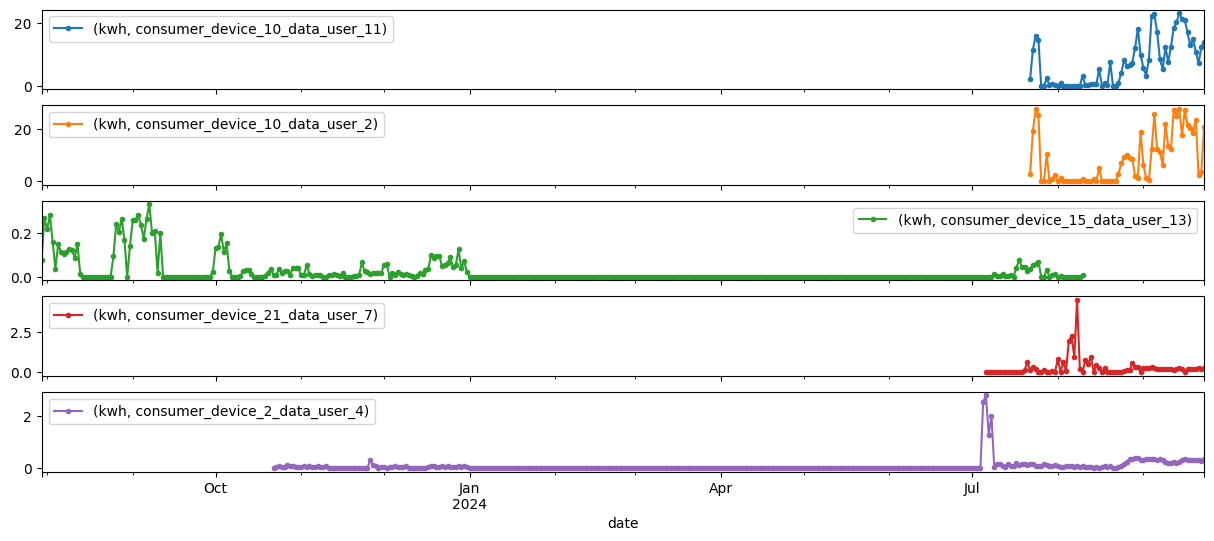

In [ ]:
list_sample_ids = df_data['source_original'].drop_duplicates().sample(5)
df_data[df_data['source_original'].isin(list_sample_ids)][['date', 'source_original', 'kwh']].set_index(['date',	'source_original']).unstack()\
.plot(style='.-', subplots=True, sharex=True, figsize=(15,6))

### **data_users and consumer_device**

Text(0, 0.5, 'Count')

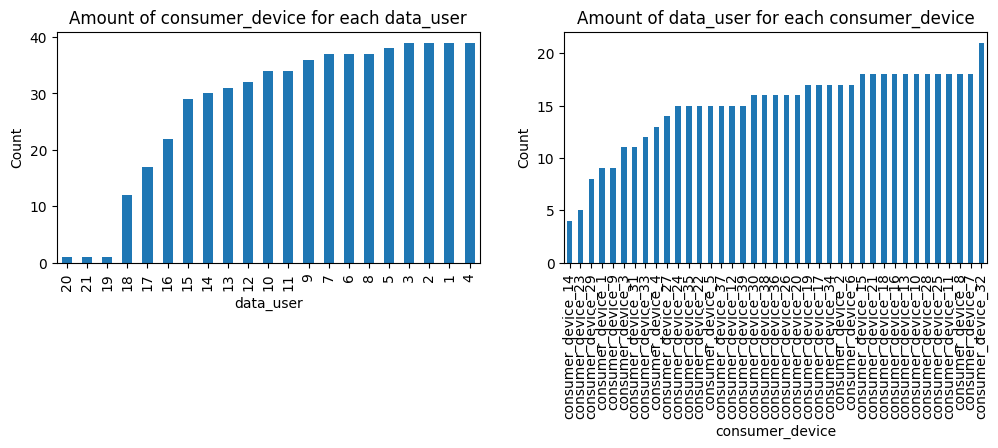

In [ ]:
f, ax = plt.subplots(1,2, figsize=(12,3))

df_data.groupby('data_user')['consumer_device'].nunique().sort_values().plot(kind='bar', ax=ax[0])
df_data.groupby('consumer_device')['data_user'].nunique().sort_values().plot(kind='bar', ax=ax[1])
ax[0].set_title('Amount of consumer_device for each data_user')
ax[0].set_ylabel('Count')
ax[1].set_title('Amount of data_user for each consumer_device')
ax[1].set_ylabel('Count')
# df_data[['data_user', 'consumer_device']].drop_duplicates()['consumer_device'].value_counts()

### **dates**

In [ ]:
## min and max dates
def func_tmp(x):
    return pd.concat([x[['date']].min(), x[['date']].max()], axis=1)
df_min_max_date = df_data[['source_original', 'date']].groupby('source_original').apply(lambda x:func_tmp(x))
df_min_max_date.columns = ['min_date', 'max_date']
df_min_max_date['diff_date'] = df_min_max_date['max_date'] - df_min_max_date['min_date']
df_min_max_date = df_min_max_date.reset_index().drop(columns='level_1')

In [ ]:
df_min_max_date.describe()

,min_date,max_date,diff_date
count,585,585,585
mean,2023-12-10 22:51:04.615000,2024-07-30 03:07:04.615000,232 days 04:16:00
min,2023-06-03 00:00:00,2023-11-20 00:00:00,39 days 00:00:00
25%,2023-10-12 00:00:00,2024-07-18 00:00:00,74 days 00:00:00
50%,2023-10-22 00:00:00,2024-09-23 00:00:00,294 days 00:00:00
75%,2023-11-25 00:00:00,2024-09-23 00:00:00,339 days 00:00:00
max,2024-08-15 00:00:00,2024-09-23 00:00:00,457 days 00:00:00
std,NaN,NaN,132 days 12:59:53.394000


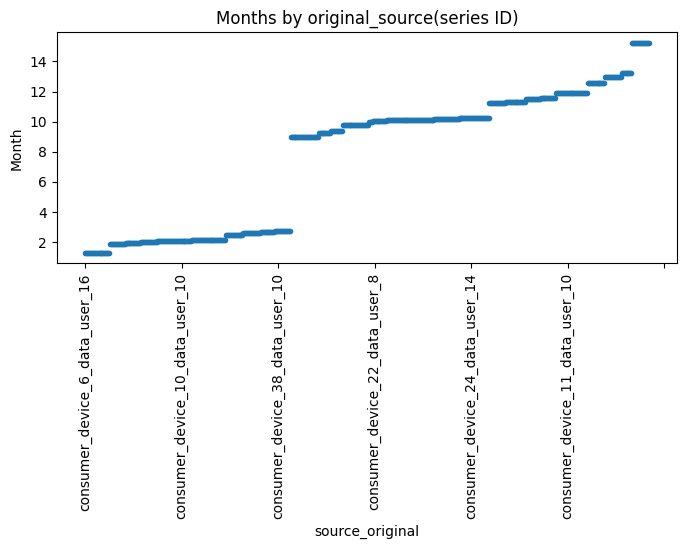

In [ ]:
## number of months between min and max dates, lenght of historical data
# This graphic show that there several user-device have only 1.3 months of history,
# the 25% of the data has 2.4 months, etc. What type of model could be used to predict this type of series
ax = (df_min_max_date.set_index('source_original')['diff_date'].dt.days/30).sort_values().plot(style='.', figsize=(8,3))
plt.xticks(rotation=90)
plt.title('Months by original_source(series ID)')
ax.set_ylabel('Month')
plt.show()

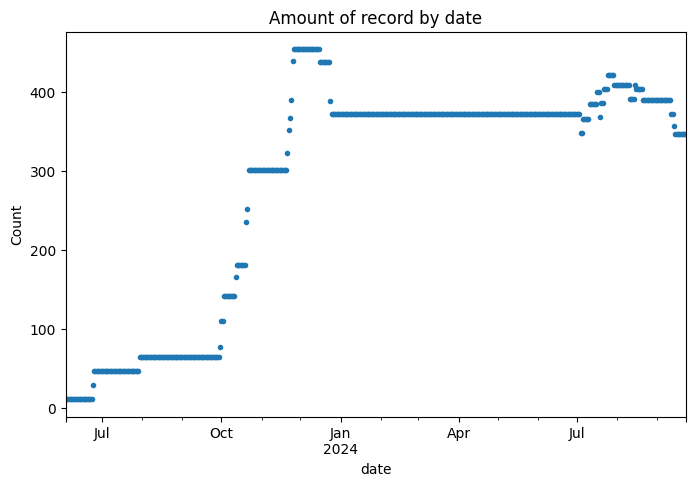

In [ ]:
# we have data from Jul 2023 with 11 Ids registered at this date, progresively incresing to around 300 to 400 ids in 2024
ax=df_data.groupby('date')['kwh'].count().sort_index().plot(style='.', figsize=(8,5))
plt.title('Amount of record by date')
ax.set_ylabel('Count')
plt.show()

### **Energy consumption KWH**

In [ ]:
def year_month_cat_plot(df, column, filter_months=0, title=''):
  filter_tmp = (df['month']>filter_months)
  color_order = list(np.arange(31)+1)
  g = sns.catplot(
      data=df[filter_tmp], kind="box",
      x="month", y=column,
      col='year',
      errorbar="sd", palette="dark",
      height=5, aspect=1.3,
      hue_order=color_order
  )
  g.despine(left=True)
  g.set_axis_labels("", "box")
  plt.subplots_adjust(top=0.85)
  plt.suptitle(title, fontsize=12)

<Axes: xlabel='kwh'>

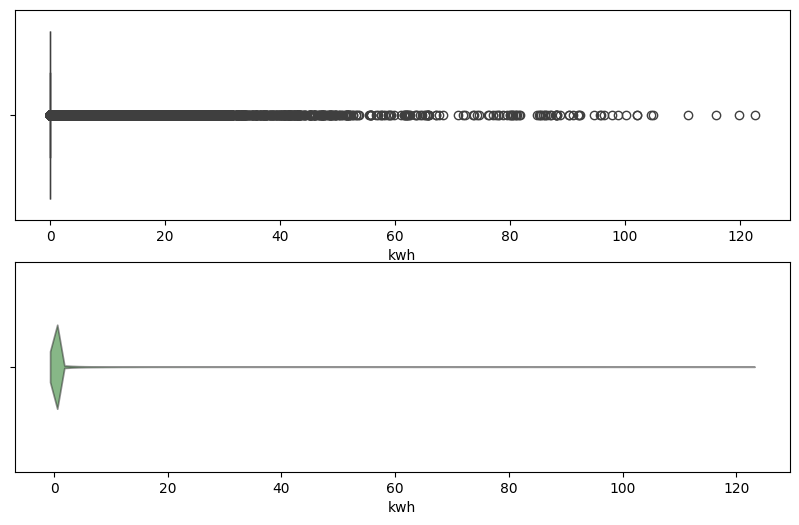

In [ ]:
column = 'kwh'
f, ax = plt.subplots(2, figsize=(10, 6))
sns.boxplot(data=df_data, x=column, orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(x=df_data[column], color="green", inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])

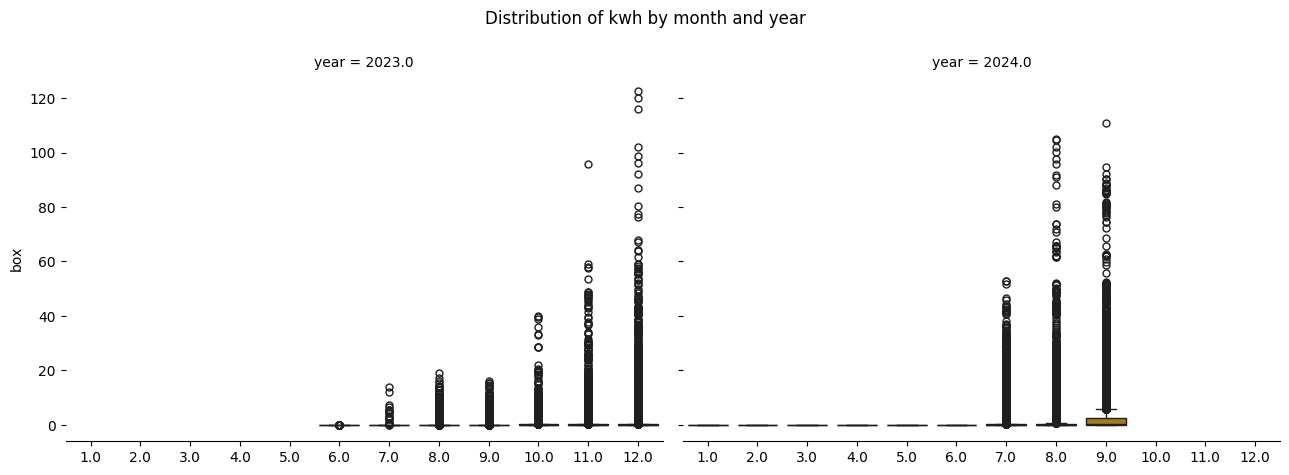

In [ ]:
year_month_cat_plot(df_data, 'kwh', filter_months=0, title='Distribution of kwh by month and year\n')

### **Voltage**

,v_red_mean,v_blue_mean,v_yellow_mean,voltage
count,48155.000000,42677.000000,45577.000000,136409.000000
mean,21.959943,20.293285,19.786932,20.712464
std,46.341692,45.027947,44.343552,45.280406
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,14.747465,7.954236,7.606458,10.493611
max,226.198299,226.090104,226.074653,226.198299


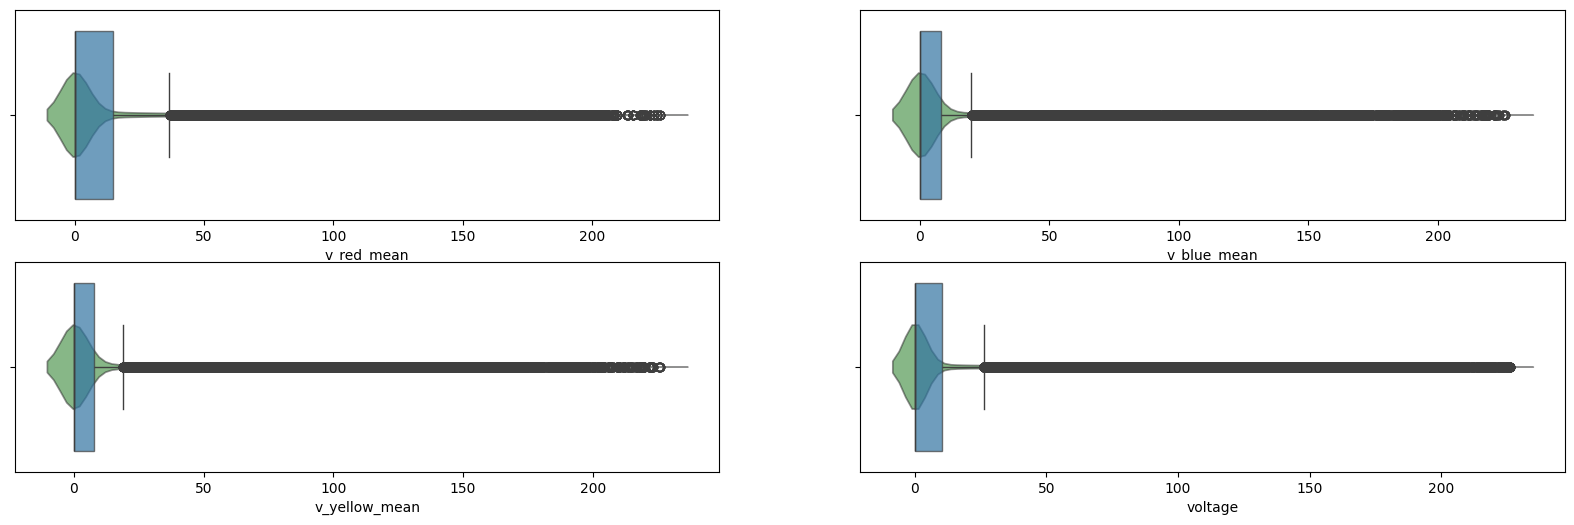

In [ ]:
column = 'v_red_mean'
f, ax = plt.subplots(2,2, figsize=(20, 6))
sns.boxplot(data=df_data, x=column, orient='h', boxprops=dict(alpha=0.7), ax=ax[0][0])
sns.violinplot(x=df_data[column], color="green", inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[0][0])

column = 'v_blue_mean'
sns.boxplot(data=df_data, x=column, orient='h', boxprops=dict(alpha=0.7), ax=ax[0][1])
sns.violinplot(x=df_data[column], color="green", inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[0][1])

column = 'v_yellow_mean'
sns.boxplot(data=df_data, x=column, orient='h', boxprops=dict(alpha=0.7), ax=ax[1][0])
sns.violinplot(x=df_data[column], color="green", inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1][0])

column = 'voltage'
sns.boxplot(data=df_data, x=column, orient='h', boxprops=dict(alpha=0.7), ax=ax[1][1])
sns.violinplot(x=df_data[column], color="green", inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1][1])

df_data[['v_red_mean', 'v_blue_mean', 'v_yellow_mean', 'voltage']].describe()

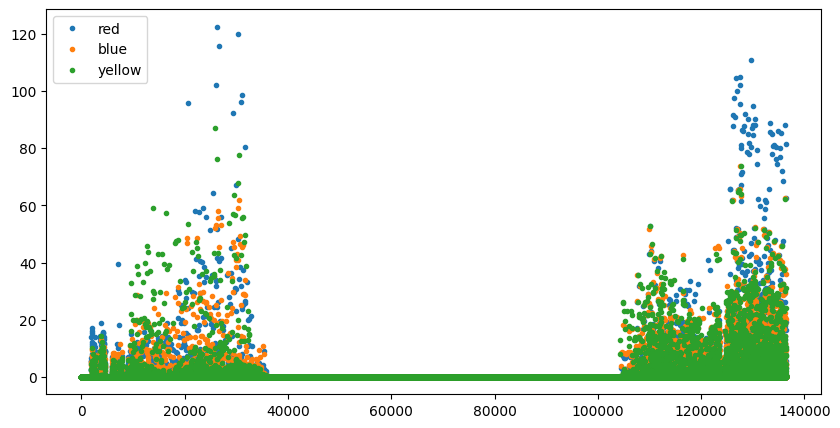

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 5))
df_data[~df_data['v_red_mean'].isna()]['kwh'].plot(style='.', ax=ax, label='red')
df_data[~df_data['v_blue_mean'].isna()]['kwh'].plot(style='.', ax=ax, label='blue')
df_data[~df_data['v_yellow_mean'].isna()]['kwh'].plot(style='.', ax=ax, label='yellow')
plt.legend()

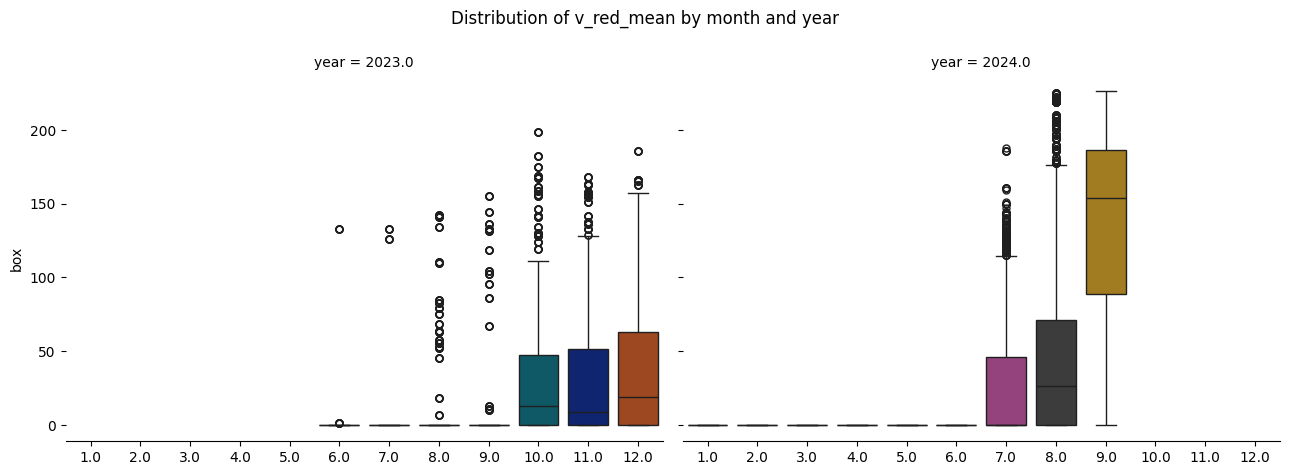

In [ ]:
year_month_cat_plot(df_data, 'v_red_mean', filter_months=0, title='Distribution of v_red_mean by month and year\n')

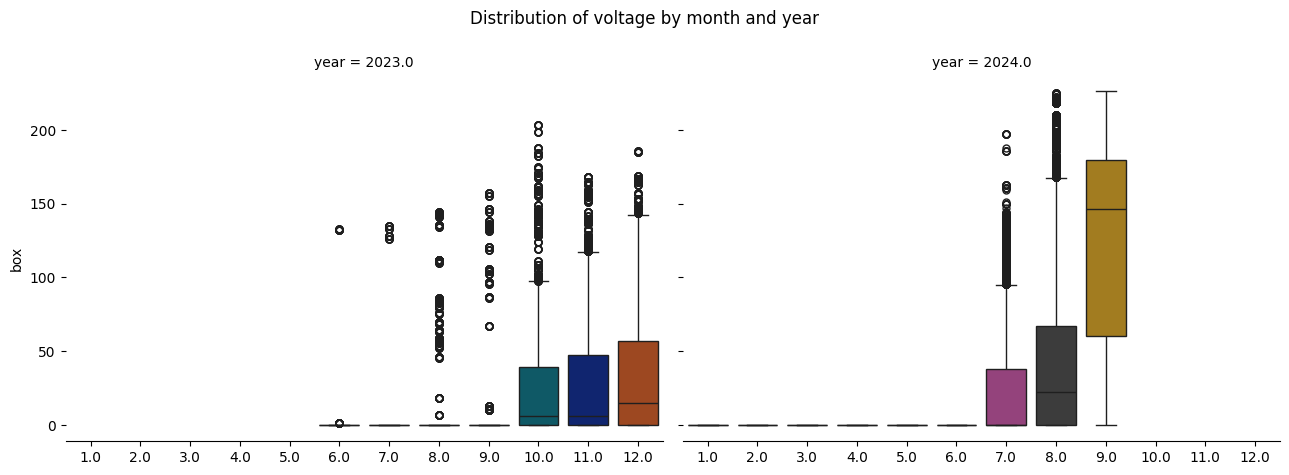

In [ ]:
year_month_cat_plot(df_data, 'voltage', filter_months=0, title='Distribution of voltage by month and year\n')

### **Current**

<Axes: xlabel='current_mean'>

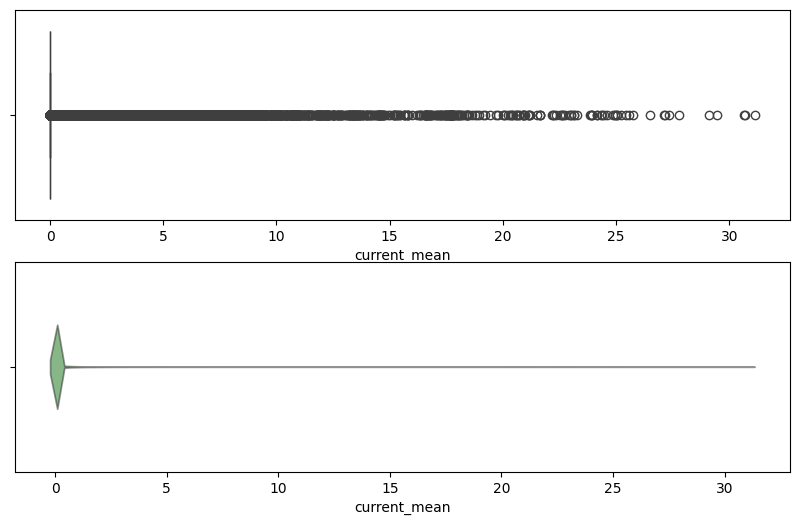

In [ ]:
column = 'current_mean'
f, ax = plt.subplots(2, figsize=(10, 6))
sns.boxplot(data=df_data, x=column, orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(x=df_data[column], color="green", inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])

In [ ]:
df_data[['current_mean', 'power_factor_mean']].describe()

,current_mean,power_factor_mean
count,136409.000000,136409.000000
mean,0.203642,0.070666
std,1.176841,0.160300
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.003368,0.015660
max,31.123333,0.964722


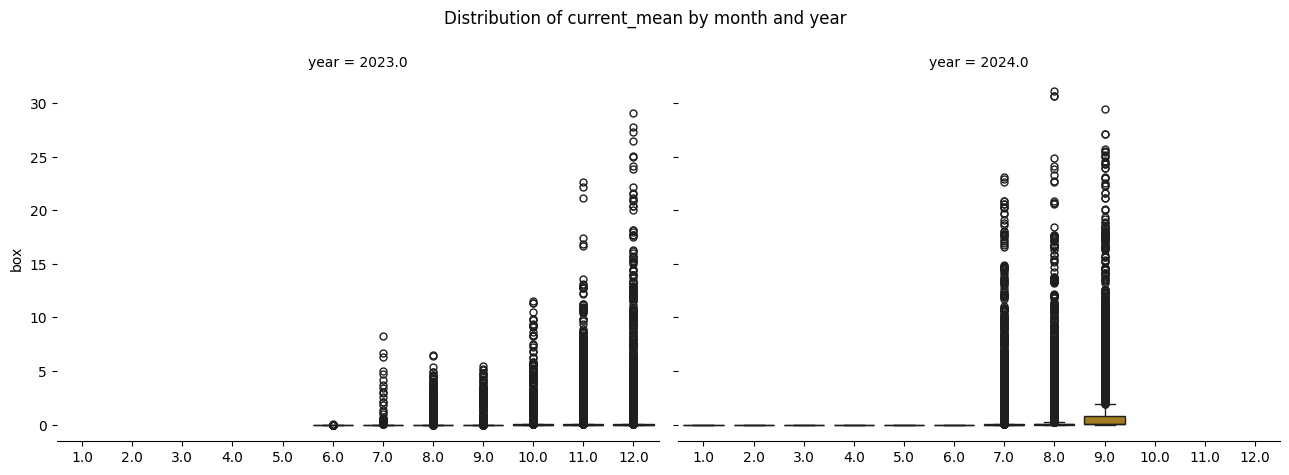

In [ ]:
year_month_cat_plot(df_data, 'current_mean', filter_months=0, title='Distribution of current_mean by month and year\n')

### **Power Factor**

<Axes: xlabel='power_factor_mean'>

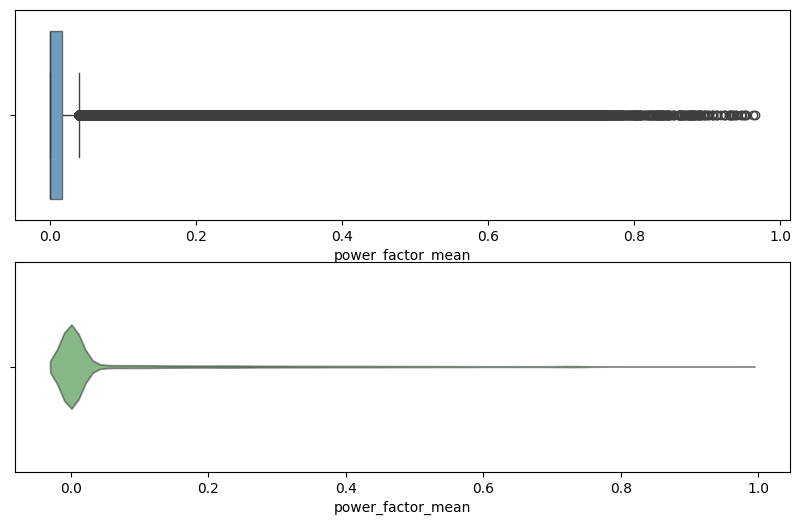

In [ ]:
column = 'power_factor_mean'
f, ax = plt.subplots(2, figsize=(10, 6))
sns.boxplot(data=df_data, x=column, orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(x=df_data[column], color="green", inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])

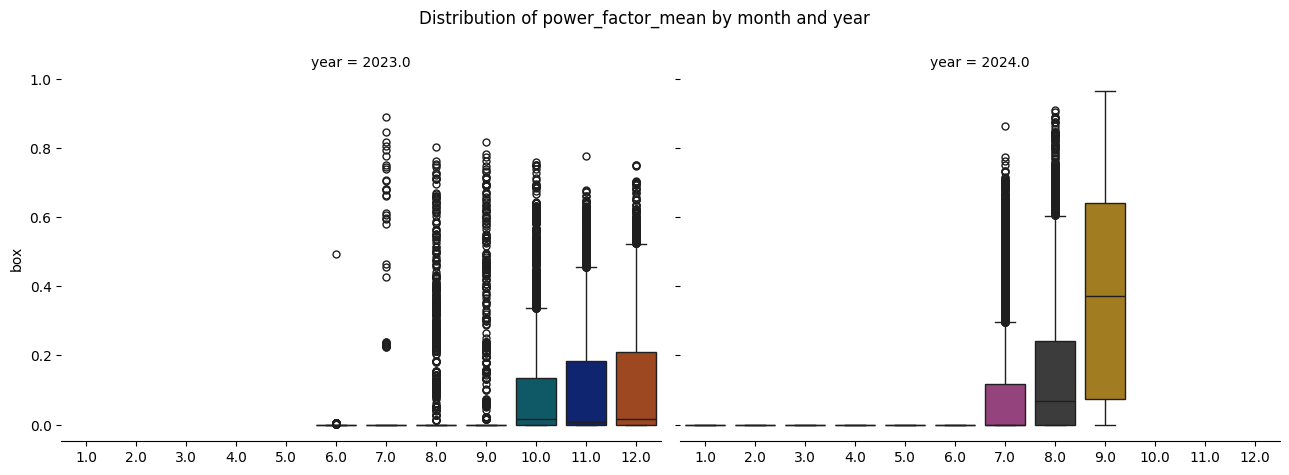

In [ ]:
year_month_cat_plot(df_data, 'power_factor_mean', filter_months=0, title='Distribution of power_factor_mean by month and year\n')

### **Climate data**

In [ ]:
df_climate.columns

Index(['date_', 'temp_mean', 'temp_median', 'temp_std', 'dew_temp_mean',
       'dew_temp_median', 'dew_temp_std', 'u_wind_mean', 'u_wind_median',
       'u_wind_std', 'v_wind_mean', 'v_wind_median', 'v_wind_std',
       'total_precip_mean', 'total_precip_median', 'total_precip_std',
       'total_precip_sum', 'snowfall_mean', 'snowfall_median', 'snowfall_std',
       'snowfall_sum', 'snow_cover_mean', 'snow_cover_median',
       'snow_cover_std', 'month', 'year', 'day'],
      dtype='object')

In [ ]:
df_climate.head()

,date_,temp_mean,temp_median,temp_std,dew_temp_mean,dew_temp_median,dew_temp_std,u_wind_mean,u_wind_median,u_wind_std,...,total_precip_median,total_precip_std,total_precip_sum,snowfall_mean,snowfall_median,snowfall_std,snowfall_sum,snow_cover_mean,snow_cover_median,snow_cover_std
0,2023-06-03,1.860280,0.660638,3.005839,-3.348664,-3.255606,0.722606,0.025054,0.045181,0.048719,...,0.000420,0.000014,0.004557,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99.972656,99.972656,0.0
1,2023-06-04,3.992740,4.405069,4.320220,-1.905203,-1.365820,1.937963,-0.180909,-0.130188,0.179358,...,0.001581,0.000721,0.024096,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99.972656,99.972656,0.0
2,2023-06-05,4.794523,5.528009,4.652554,-3.781657,-3.834784,1.384712,-0.145114,-0.040283,0.240666,...,0.000635,0.000357,0.011580,4.858333e-08,5.220000e-08,1.498822e-08,1.166000e-06,99.972656,99.972656,0.0
3,2023-06-06,6.304390,6.563387,3.761622,-4.670615,-4.668463,1.128644,0.018054,0.028160,0.133539,...,0.000558,0.000264,0.008914,2.175000e-09,0.000000e+00,1.065528e-08,5.220000e-08,99.972656,99.972656,0.0
4,2023-06-07,7.003922,7.008661,3.768528,-3.965763,-4.236990,1.188614,0.083701,0.044258,0.214731,...,0.000562,0.000261,0.008649,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,99.972656,99.972656,0.0


In [ ]:
dict_tmp, df_result = type_and_nulls(df_climate, display_null_features=True, p_nulls=50)

shape data: 511 27


,count
float64,23
int32,3
datetime64[ns],1


Amount of nulls features:  7
Amount of not null features:  20

float64 | total: 23
____ % nulls <= 50 % 23 ____ 
____ % nulls >  50 % 0 ____ 


,%nulls



int32 | total: 3
____ % nulls <= 50 % 3 ____ 
____ % nulls >  50 % 0 ____ 


,%nulls



datetime64[ns] | total: 1
____ % nulls <= 50 % 1 ____ 
____ % nulls >  50 % 0 ____ 


,%nulls


In [ ]:
np.min(df_climate['date_']), np.max(df_climate['date_'])

(Timestamp('2023-06-03 00:00:00'), Timestamp('2024-10-25 00:00:00'))

### **Temperature**

,temp_mean,temp_median,temp_std
count,511.000000,511.000000,510.000000
mean,2.594479,2.369402,3.430956
std,9.719811,10.078660,1.040719
min,-16.995727,-18.373785,0.640453
25%,-6.611991,-7.011145,2.825966
50%,4.741668,4.373300,3.452181
75%,11.431838,11.546762,4.093926
max,16.611638,16.849245,6.683088


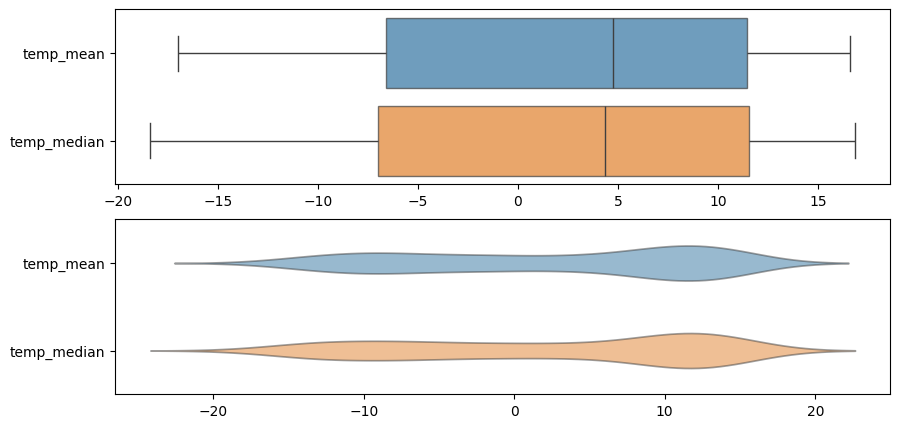

In [ ]:
column = ['temp_mean', 'temp_median']
f, ax = plt.subplots(2, figsize=(10, 5))
sns.boxplot(data=df_climate[column], orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(data=df_climate[column], orient='h', inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])
df_climate[['temp_mean', 'temp_median', 'temp_std']].describe()

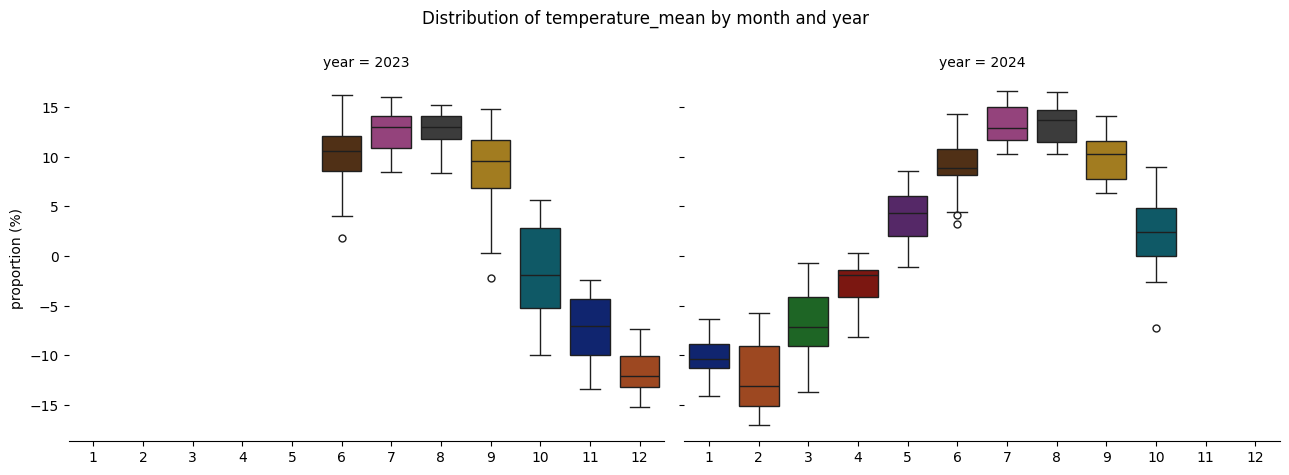

In [ ]:
year_month_cat_plot(df_climate, 'temp_mean', filter_months=0, title='Distribution of temperature_mean by month and year\n')

### **Dew Temperature**

,dew_temp_mean,dew_temp_median,dew_temp_std
count,511.000000,511.000000,510.000000
mean,-3.287640,-3.109312,2.181151
std,11.081899,11.046045,1.143986
min,-28.874546,-29.212340,0.373643
25%,-12.288426,-11.525042,1.355226
50%,-1.493778,-1.071379,1.853548
75%,6.529089,6.788747,2.840898
max,13.005553,12.791963,7.130807


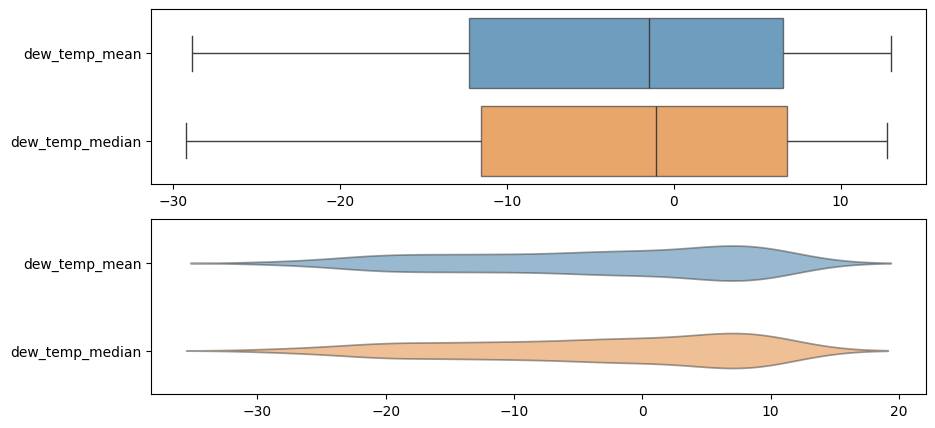

In [ ]:
column = ['dew_temp_mean', 'dew_temp_median']
f, ax = plt.subplots(2, figsize=(10, 5))
sns.boxplot(data=df_climate[column], orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(data=df_climate[column], orient='h', inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])
df_climate[column+ ['dew_temp_std']].describe()

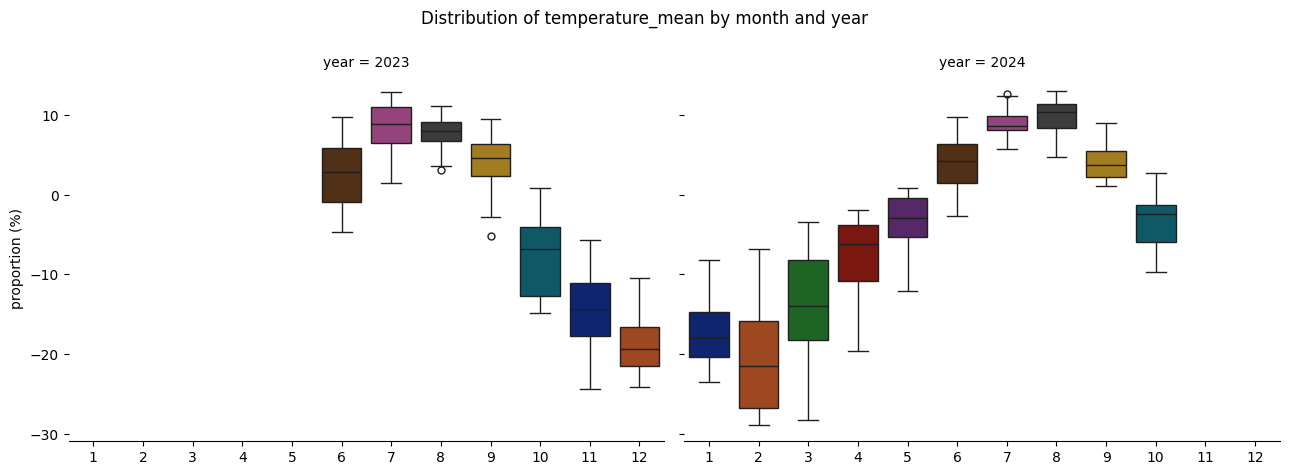

In [ ]:
year_month_cat_plot(df_climate, 'dew_temp_mean', filter_months=0, title='Distribution of temperature_mean by month and year\n')

### **Wind**

,u_wind_mean,u_wind_median,u_wind_std
count,511.000000,511.000000,510.000000
mean,0.003960,0.015691,0.165202
std,0.133919,0.122698,0.075222
min,-0.604294,-0.648354,0.028589
25%,-0.062848,-0.036564,0.097642
50%,0.007388,0.022090,0.166033
75%,0.075657,0.072182,0.223125
max,0.441994,0.437950,0.398770


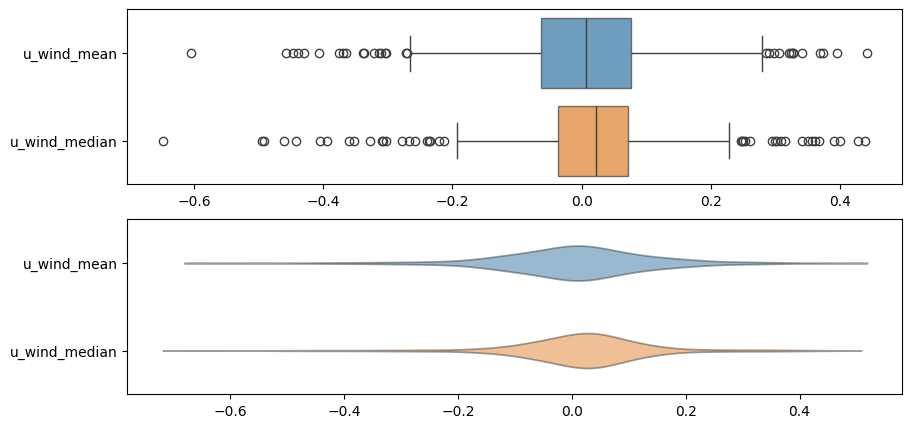

In [ ]:
column = ['u_wind_mean', 'u_wind_median']
f, ax = plt.subplots(2, figsize=(10, 5))
sns.boxplot(data=df_climate[column], orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(data=df_climate[column], orient='h', inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])
df_climate[column+ ['u_wind_std']].describe()

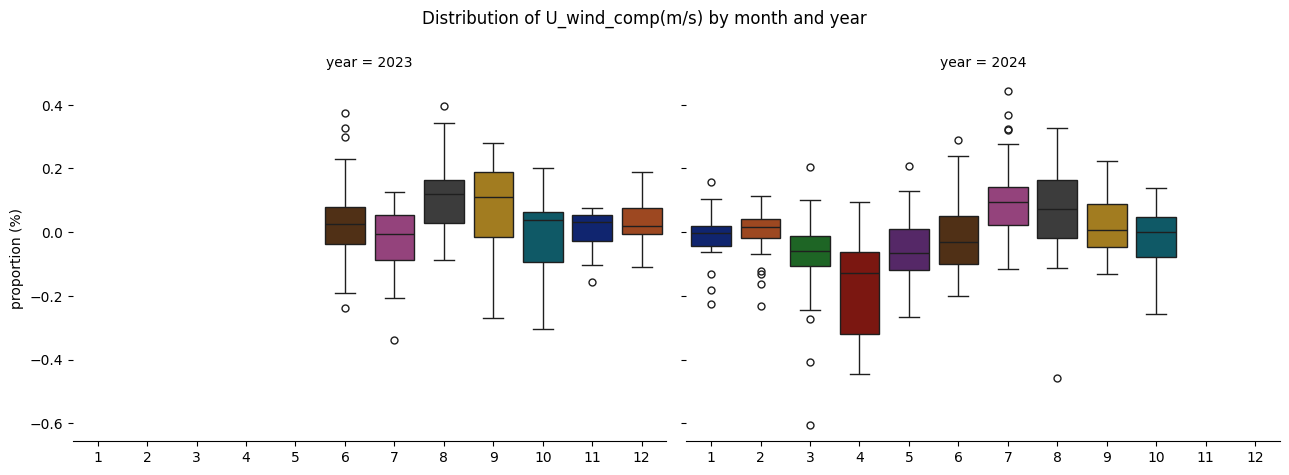

In [ ]:
year_month_cat_plot(df_climate, 'u_wind_mean', filter_months=0, title='Distribution of U_wind_comp(m/s) by month and year\n')

,v_wind_mean,v_wind_median,v_wind_std
count,511.000000,511.000000,510.000000
mean,-0.333363,-0.442440,0.470377
std,0.445294,0.445927,0.190447
min,-1.251801,-1.258070,0.102256
25%,-0.722901,-0.813473,0.290543
50%,-0.278123,-0.443953,0.470930
75%,0.053536,-0.097928,0.648519
max,0.528192,0.565827,0.848419


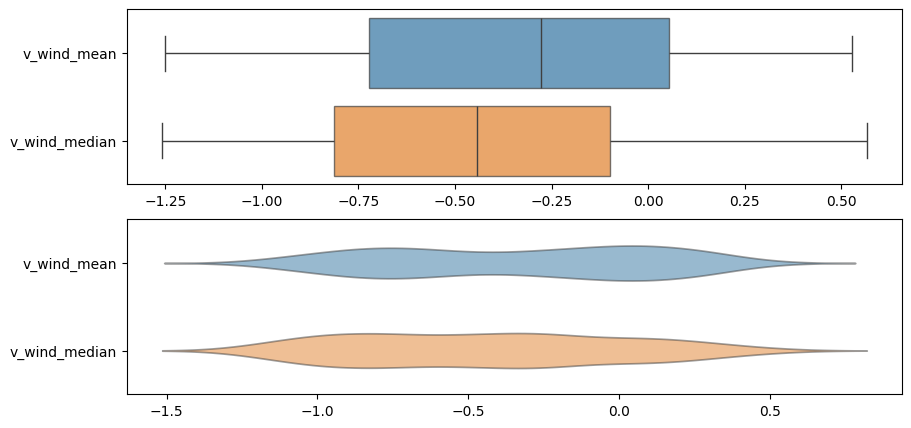

In [ ]:
#v_wind
column = ['v_wind_mean', 'v_wind_median']
f, ax = plt.subplots(2, figsize=(10, 5))
sns.boxplot(data=df_climate[column], orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(data=df_climate[column], orient='h', inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])
df_climate[column+ ['v_wind_std']].describe()

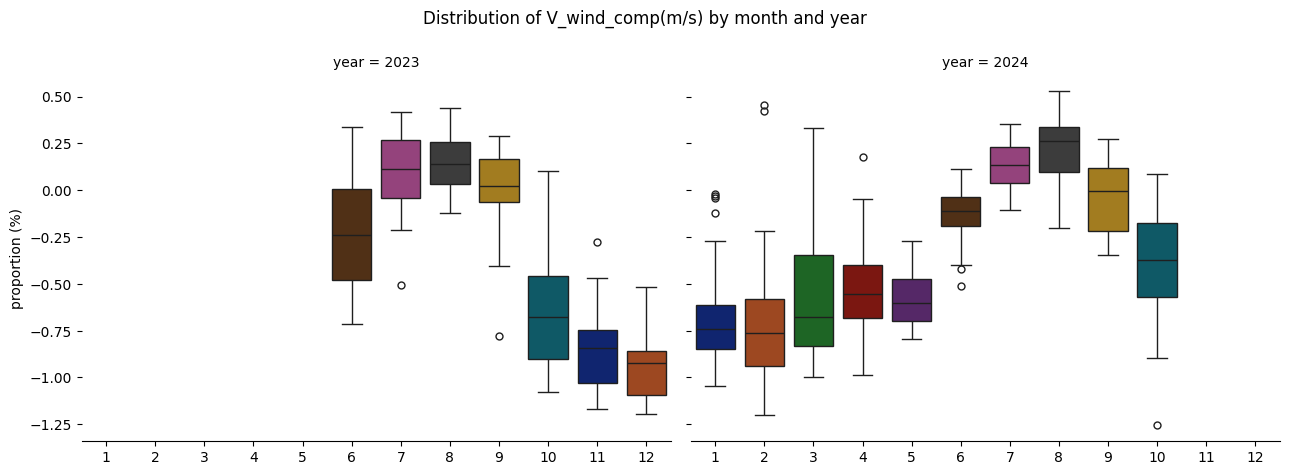

In [ ]:
year_month_cat_plot(df_climate, 'v_wind_mean', filter_months=0, title='Distribution of V_wind_comp(m/s) by month and year\n')

### **Precipitation**

,total_precip_sum,total_precip_std
count,511.000000,510.000000
mean,0.051013,0.001543
std,0.100816,0.002537
min,0.000000,0.000000
25%,0.001452,0.000085
50%,0.016186,0.000680
75%,0.059839,0.001960
max,0.919713,0.020300


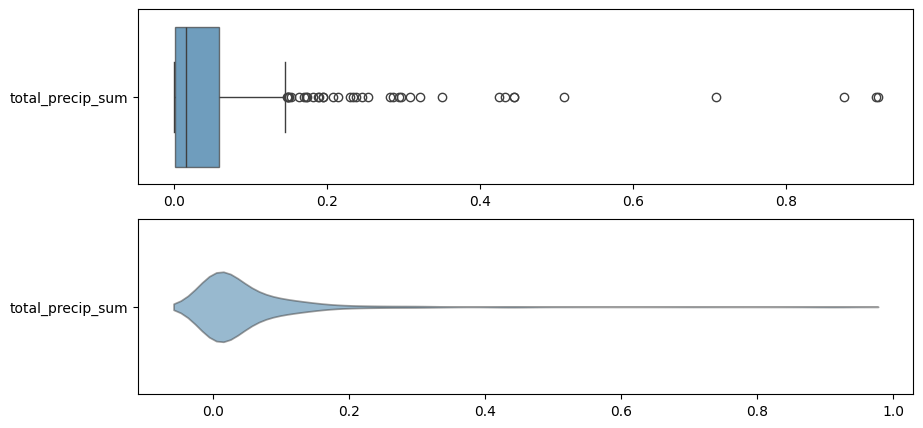

In [ ]:
column = ['total_precip_sum']
f, ax = plt.subplots(2, figsize=(10, 5))
sns.boxplot(data=df_climate[column], orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(data=df_climate[column], orient='h', inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])
df_climate[column+ ['total_precip_std']].describe()

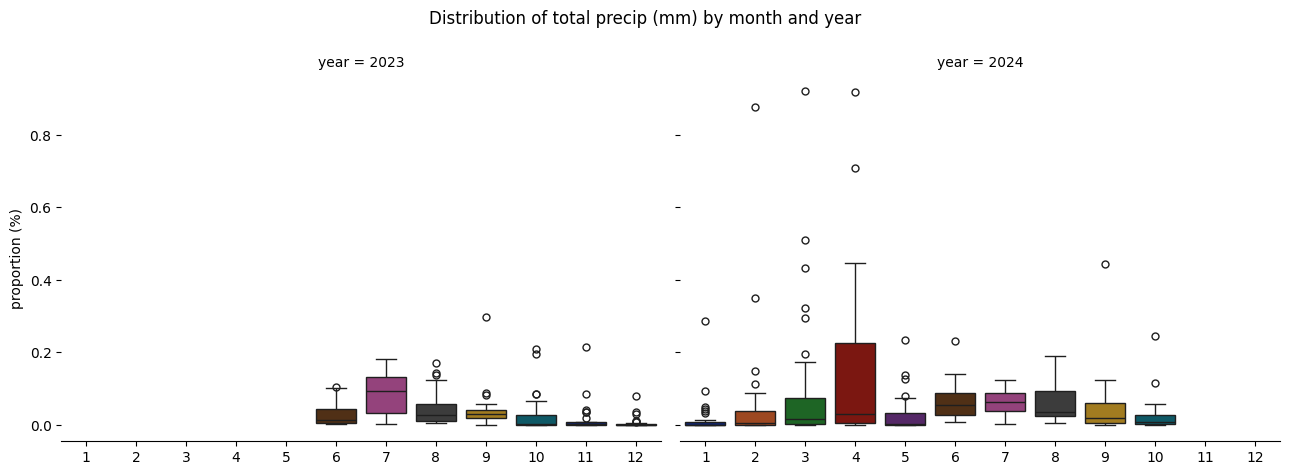

In [ ]:
year_month_cat_plot(df_climate, 'total_precip_sum', filter_months=0, title='Distribution of total precip (mm) by month and year\n')

### **Snow**

,snowfall_sum,snowfall_std
count,5.110000e+02,5.100000e+02
mean,2.424480e-02,7.759863e-04
std,9.604876e-02,2.453871e-03
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,3.540000e-07,2.381951e-08
75%,1.744583e-03,1.492479e-04
max,9.189855e-01,2.028383e-02


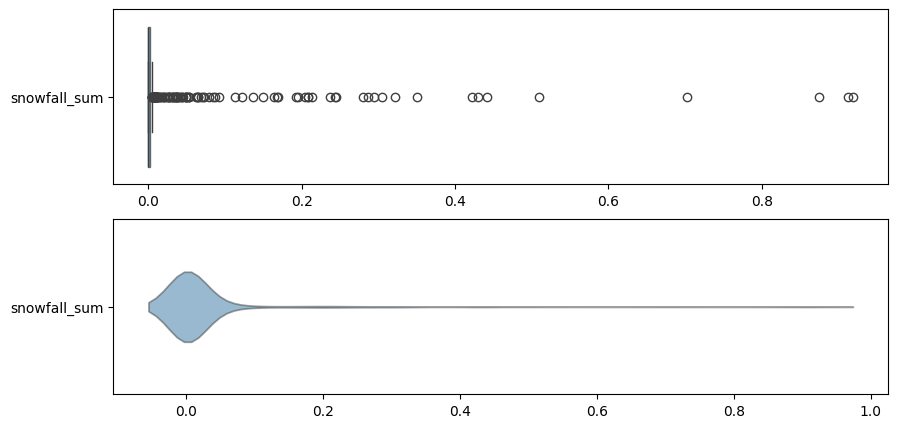

In [ ]:
column = ['snowfall_sum']
f, ax = plt.subplots(2, figsize=(10, 5))
sns.boxplot(data=df_climate[column], orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(data=df_climate[column], orient='h', inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])
df_climate[column+ ['snowfall_std']].describe()

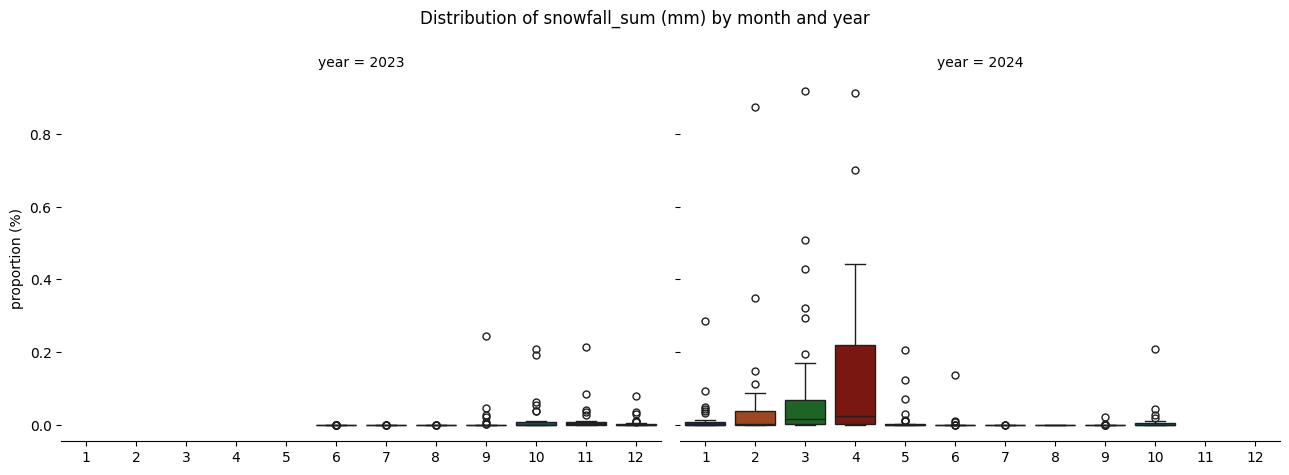

In [ ]:
year_month_cat_plot(df_climate, 'snowfall_sum', filter_months=0, title='Distribution of snowfall_sum (mm) by month and year\n')

,snow_cover_mean,snow_cover_median,snow_cover_std,snow_cover_std
count,511.000000,511.000000,510.000000,510.000000
mean,52.363831,52.049898,0.706327,0.706327
std,47.658092,47.739977,2.576761,2.576761
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,59.048014,53.025391,0.000000,0.000000
75%,99.972656,99.972656,0.000000,0.000000
max,99.972656,99.972656,29.686610,29.686610


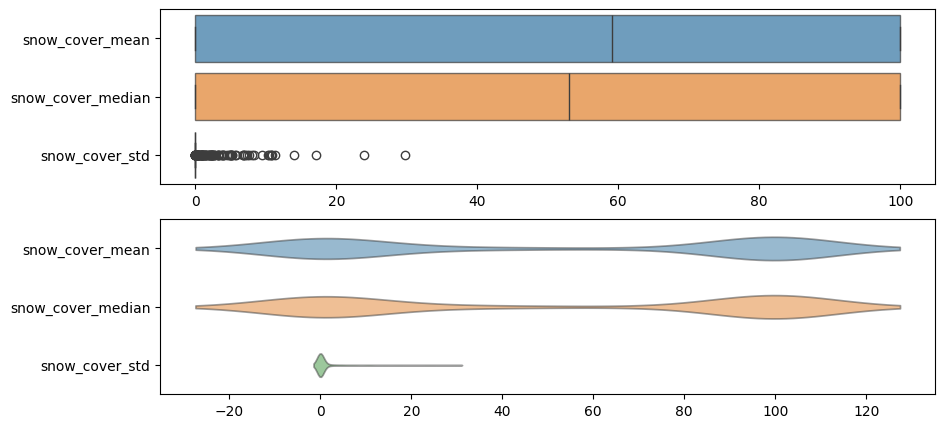

In [ ]:
column = ['snow_cover_mean', 'snow_cover_median', 'snow_cover_std']

f, ax = plt.subplots(2, figsize=(10, 5))
sns.boxplot(data=df_climate[column], orient='h', boxprops=dict(alpha=0.7), ax=ax[0])
sns.violinplot(data=df_climate[column], orient='h', inner=None, width=0.4, density_norm="count", alpha=0.5, ax=ax[1])
df_climate[column+ ['snow_cover_std']].describe()

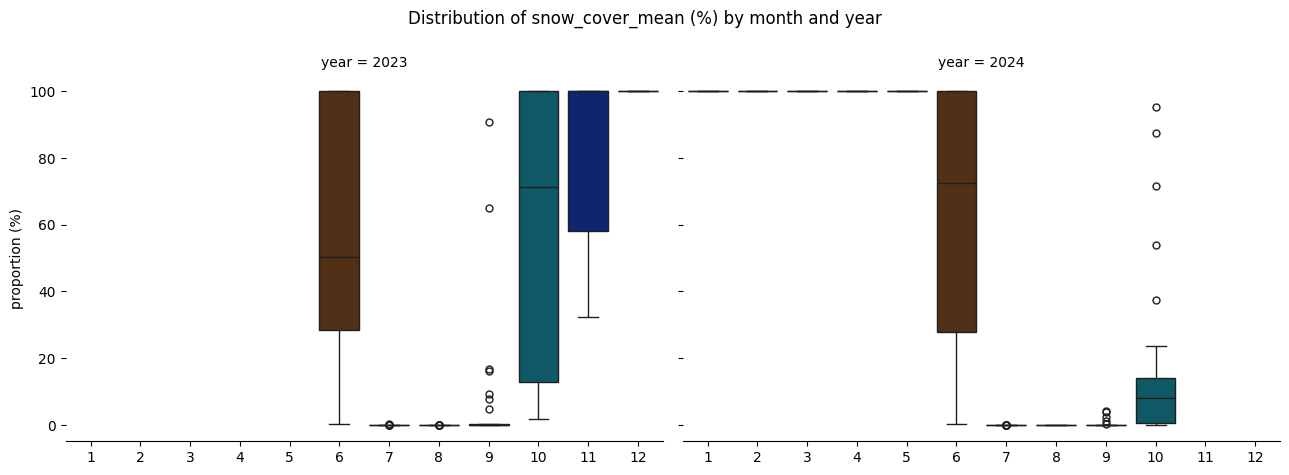

In [ ]:
year_month_cat_plot(df_climate, 'snow_cover_mean', filter_months=0, title='Distribution of snow_cover_mean (%) by month and year\n')

## Multivariate analysis

In [ ]:
def correlation_heatmap(df, columns, figsize=(12, 9), sort_more_corr=True, plot=True):
    corrmat = df[columns].corr().round(4)
    if sort_more_corr:
        sorted_columns = corrmat.sum(axis=1).sort_values().index.values
        corrmat = corrmat.loc[sorted_columns][sorted_columns]
    if plot:
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corrmat, vmax=.8, square=True)
    return corrmat

,voltage,power_factor_mean,current_mean,kwh
voltage,1.0000,0.8650,0.3499,0.3610
power_factor_mean,0.8650,1.0000,0.4278,0.4237
current_mean,0.3499,0.4278,1.0000,0.9567
kwh,0.3610,0.4237,0.9567,1.0000


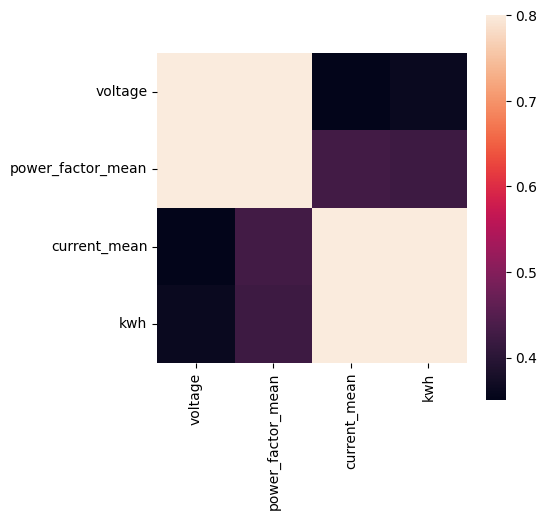

In [ ]:
## The value of current is high correlated with the consumption
## The value of voltage with power factor are higher correlated
## power factor is 42% correlated with current and consumption

columns_tmp = ['voltage', 'current_mean', 'power_factor_mean', 'kwh']
correlation_heatmap(df_data, columns_tmp, figsize=(5, 5))

<Axes: xlabel='power_factor_mean', ylabel='kwh'>

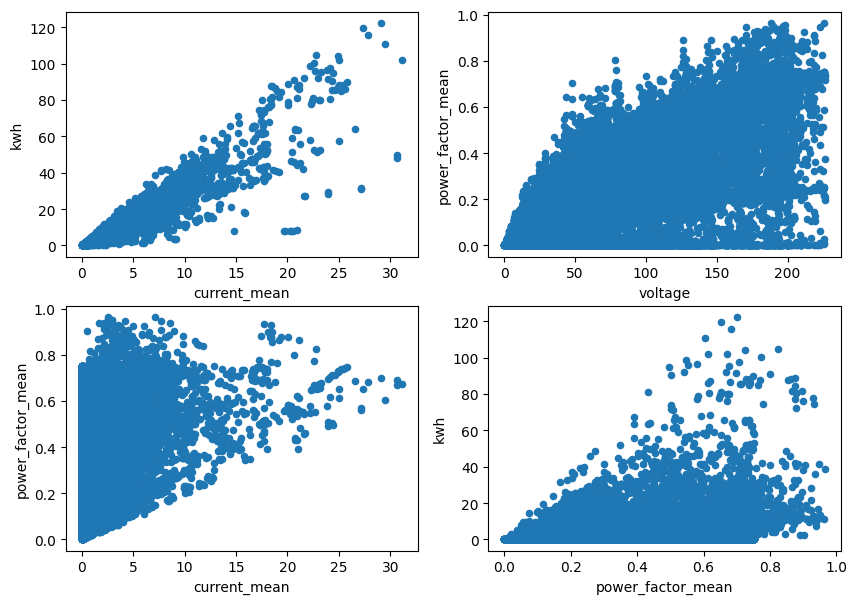

In [ ]:
f, ax = plt.subplots(2,2, figsize=(10,7))
df_data.plot(kind='scatter', x='current_mean', y='kwh', ax=ax[0][0])
df_data.plot(kind='scatter', x='voltage', y='power_factor_mean', ax=ax[0][1])
df_data.plot(kind='scatter', x='current_mean', y='power_factor_mean', ax=ax[1][0])
df_data.plot(kind='scatter', x='power_factor_mean', y='kwh', ax=ax[1][1])

,snow_cover_mean,u_wind_mean,snowfall_sum,temp_mean,total_precip_sum,dew_temp_mean,v_wind_mean
snow_cover_mean,1.0000,-0.3602,0.2314,-0.8039,0.0153,-0.7913,-0.7561
u_wind_mean,-0.3602,1.0000,-0.3773,0.2651,-0.3305,0.2188,0.2684
snowfall_sum,0.2314,-0.3773,1.0000,-0.1702,0.9045,-0.0617,0.0996
temp_mean,-0.8039,0.2651,-0.1702,1.0000,0.0486,0.9524,0.8328
total_precip_sum,0.0153,-0.3305,0.9045,0.0486,1.0000,0.1897,0.3274
dew_temp_mean,-0.7913,0.2188,-0.0617,0.9524,0.1897,1.0000,0.8914
v_wind_mean,-0.7561,0.2684,0.0996,0.8328,0.3274,0.8914,1.0000


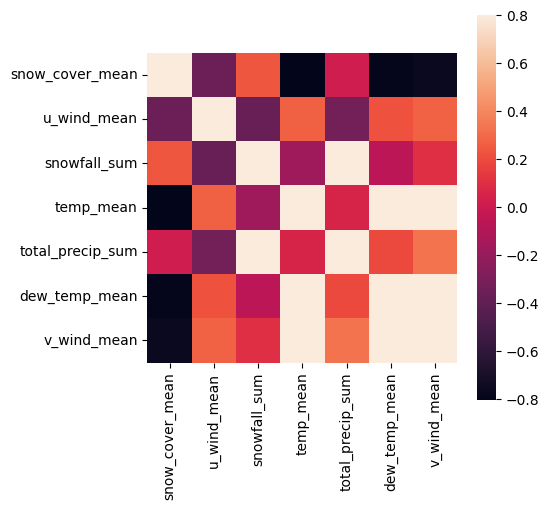

In [ ]:
columns_tmp = ['temp_mean', 'dew_temp_mean', 'u_wind_mean', 'v_wind_mean', 'total_precip_sum', 'snowfall_sum', 'snow_cover_mean']
correlation_heatmap(df_climate, columns_tmp, figsize=(5, 5))

In [ ]:
climate_columns = ['temp_mean', 'dew_temp_mean', 'u_wind_mean', 'v_wind_mean', 'total_precip_sum', 'snowfall_sum', 'snow_cover_mean']
energy_columns = ['voltage', 'current_mean', 'power_factor_mean', 'kwh']

,snow_cover_mean,u_wind_mean,snowfall_sum,total_precip_sum,voltage,temp_mean,power_factor_mean,kwh,current_mean,dew_temp_mean,v_wind_mean
snow_cover_mean,1.0000,-0.3664,0.2007,0.0056,-0.3745,-0.8207,-0.3439,-0.1615,-0.1689,-0.7979,-0.7640
u_wind_mean,-0.3664,1.0000,-0.4080,-0.3750,0.0876,0.2249,0.0982,0.0329,0.0410,0.1638,0.1800
snowfall_sum,0.2007,-0.4080,1.0000,0.9451,-0.1148,-0.1241,-0.1099,-0.0420,-0.0449,-0.0115,0.1696
total_precip_sum,0.0056,-0.3750,0.9451,1.0000,-0.0723,0.0750,-0.0688,-0.0153,-0.0161,0.2019,0.3585
voltage,-0.3745,0.0876,-0.1148,-0.0723,1.0000,0.2211,0.8650,0.3610,0.3499,0.2076,0.1617
temp_mean,-0.8207,0.2249,-0.1241,0.0750,0.2211,1.0000,0.2018,0.1102,0.1159,0.9575,0.8352
power_factor_mean,-0.3439,0.0982,-0.1099,-0.0688,0.8650,0.2018,1.0000,0.4237,0.4278,0.1917,0.1455
kwh,-0.1615,0.0329,-0.0420,-0.0153,0.3610,0.1102,0.4237,1.0000,0.9567,0.1059,0.0929
current_mean,-0.1689,0.0410,-0.0449,-0.0161,0.3499,0.1159,0.4278,0.9567,1.0000,0.1119,0.0966
dew_temp_mean,-0.7979,0.1638,-0.0115,0.2019,0.2076,0.9575,0.1917,0.1059,0.1119,1.0000,0.8896


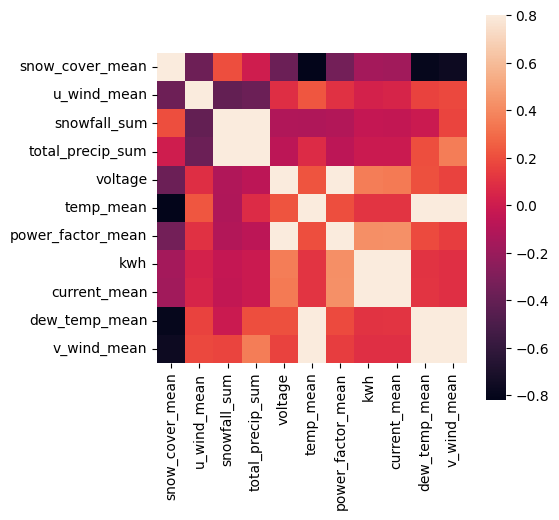

In [ ]:
correlation_heatmap(df_data.merge(df_climate[climate_columns+['date_']],
                                  how='inner',
                                  left_on='date',
                                  right_on='date_'),
                    climate_columns+energy_columns,
                    figsize=(5, 5))

## Plot series by consumer device

In [ ]:
df_data['consumer_device'].drop_duplicates().sample(3).values

array(['consumer_device_6', 'consumer_device_2', 'consumer_device_9'],
      dtype=object)

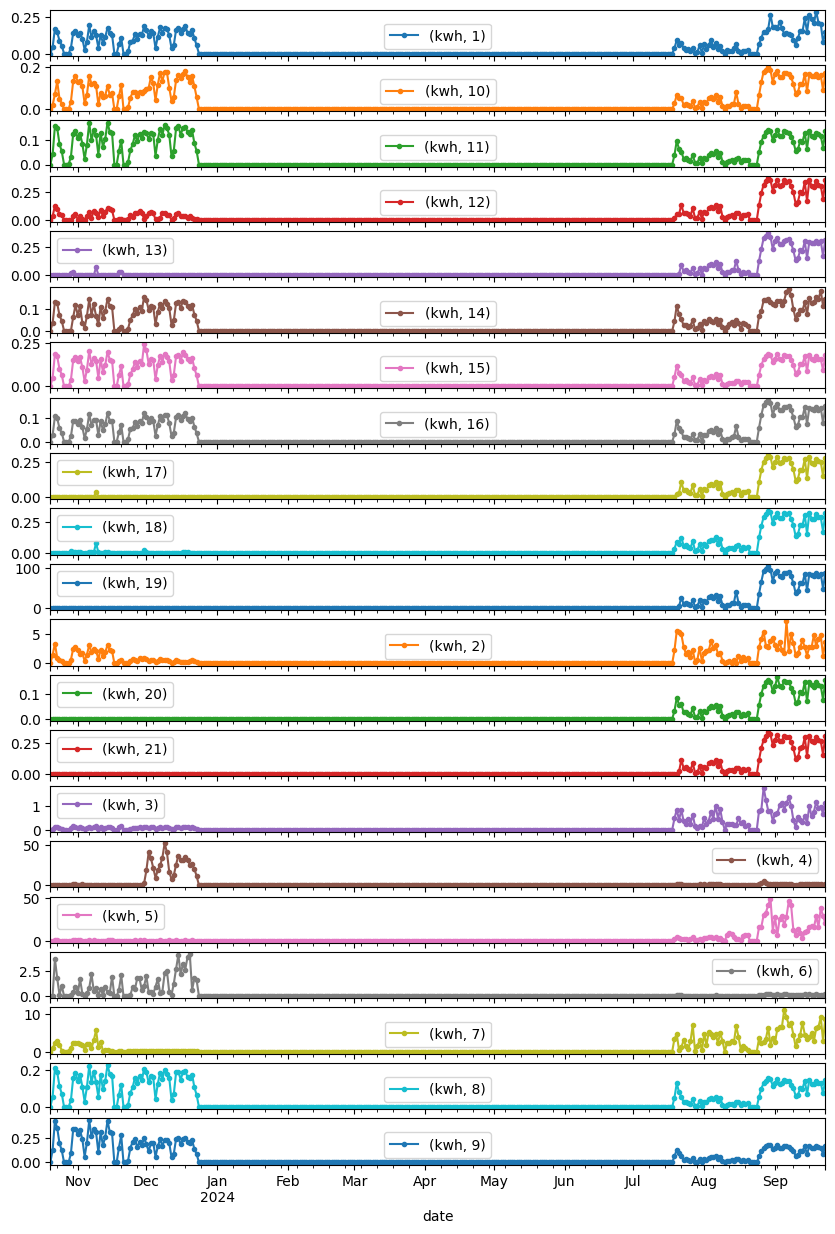

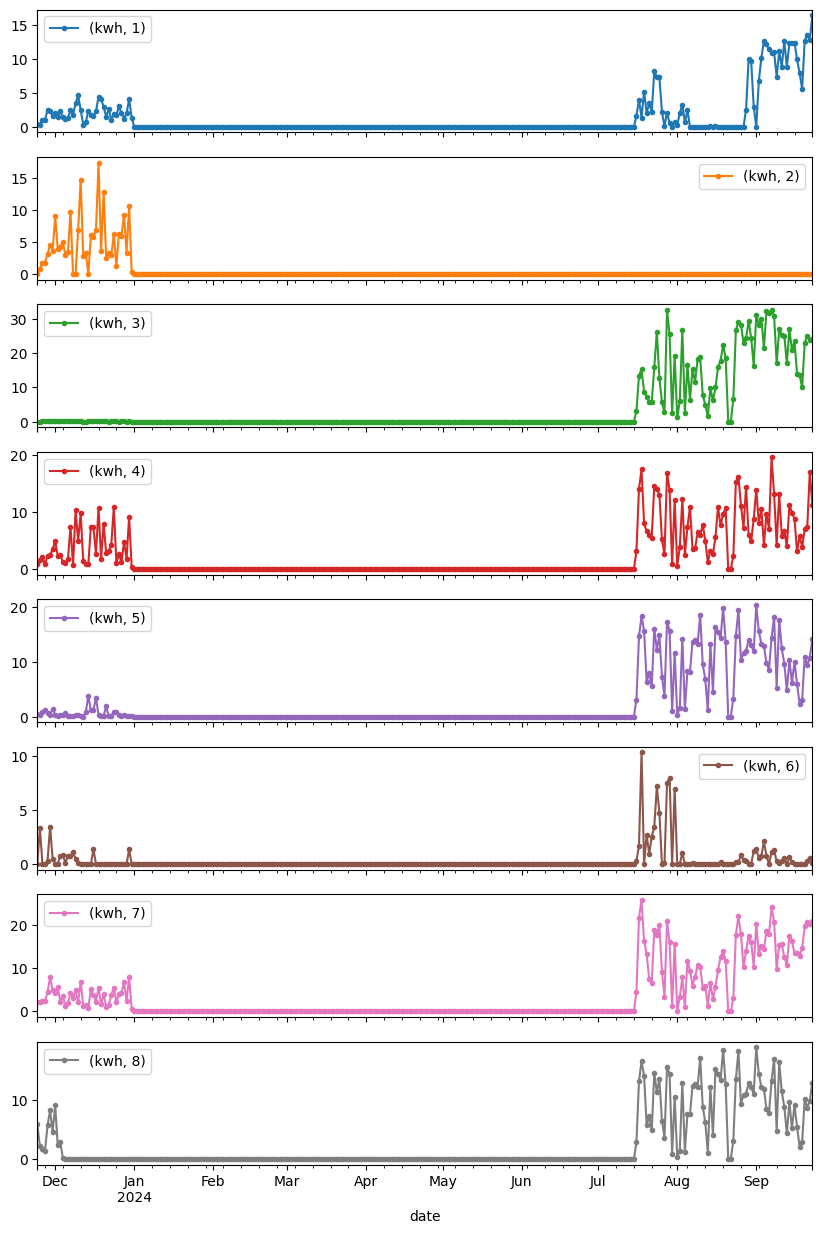

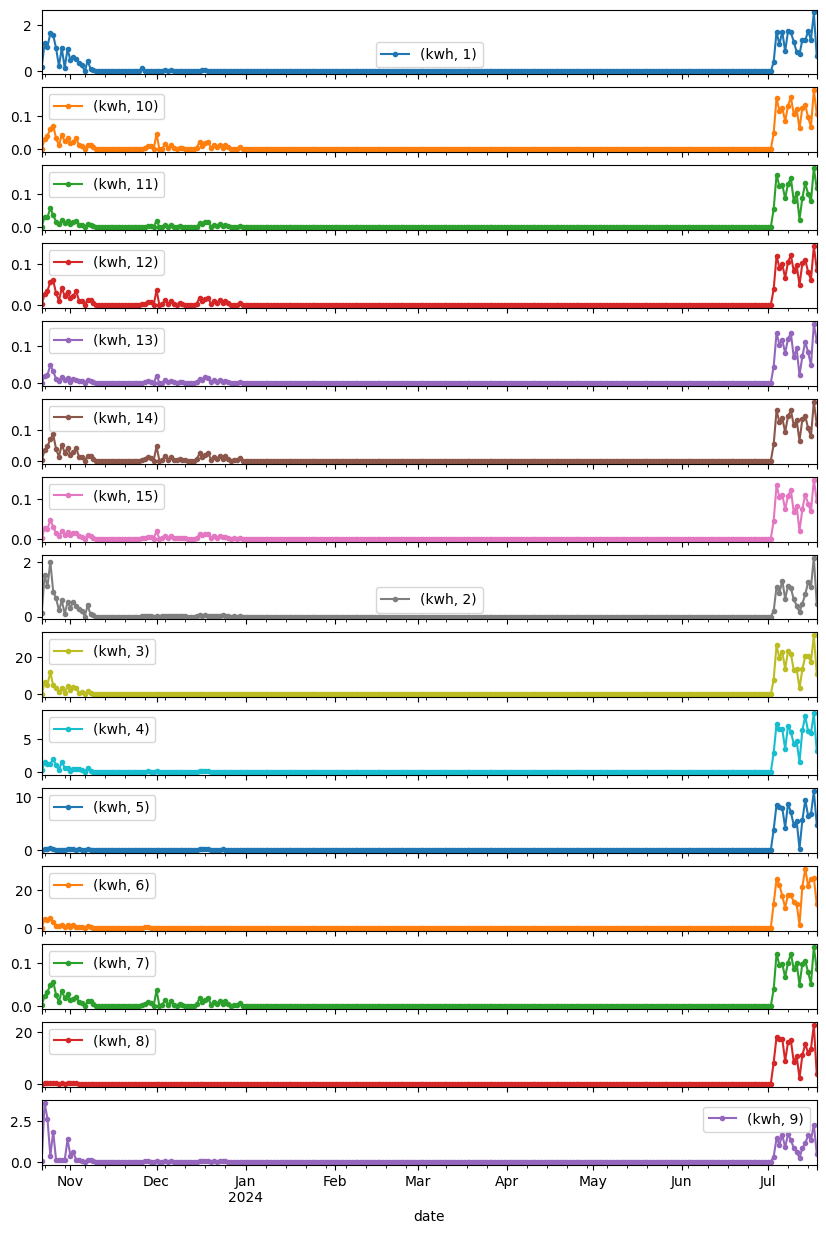

In [ ]:
#check the series by consumer_device #22
for cd in df_data['consumer_device'].drop_duplicates().sample(3).values:
  df_data[df_data['consumer_device'] == cd][['date', 'data_user', 'kwh']].set_index(['date',	'data_user']).unstack()\
  .plot(style='.-', subplots=True, sharex=True, figsize=(10,15)) #